In [1]:
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import SimpleITK as sitk
from PIL import Image
from keras.callbacks import ModelCheckpoint
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.activations import *
from keras.preprocessing.image import ImageDataGenerator
 
from keras.layers import BatchNormalization
from keras.losses import binary_crossentropy
from PIL import Image
from skimage import metrics
from skimage import data, exposure, img_as_float

Using TensorFlow backend.


## Preprocessing functions

In [2]:
# Contrast stretching
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

# Histogram equalization
def HE(img):
    img_eq = exposure.equalize_hist(img)
    return img_eq

# Adaptive histogram equalization
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

## Loss and evaluation functions

In [3]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

##Loss function 
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

## Dice score and Hausdorff and Mean Hausdorff scores

In [4]:
def DHR(src):
    #src = cv2.imread(imgpath)
    grayScale = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY )
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(10,10))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    ret,thresh2 = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    dst = cv2.inpaint(src,thresh2,1,cv2.INPAINT_TELEA)
    return dst 


def save_result(model, data_root, predict_root, gt_root=None):
    img_path = []
    img_path += glob.glob(os.path.join(data_root, 'image/*.jpg'))
    img_path = sorted(img_path)

    label_path = []
    label_path += glob.glob(os.path.join(data_root, 'label/*.png'))
    label_path = sorted(label_path)

    count = 0
    avgDice = 0
    avgHaus = 0
    avgMean = 0
    single_quality = 0
    quality = 0
    for i in range(len(label_path)):
        filename = img_path[i].split('/')[-1]
        labelFileName = img_path[i]
        labelFileName = labelFileName.replace(".jpg", "_segmentation.png")
        labelFileName = labelFileName.replace("image", "label")
        
        
        img = mpimg.imread(img_path[i])
        label = mpimg.imread(labelFileName)
        target = cv2.imread(labelFileName)

        imgInput = cv2.imread(img_path[i])
        imgInput = DHR(imgInput)
        imgInput = np.expand_dims(imgInput, axis = 0)
        output = model.predict(imgInput/255.0)
        output = output[0]
        print(np.max(output))
        print(np.min(output))

        pred = np.round(output) * 255.0 
        print(np.max(pred))
        print(np.min(pred))
        zeros = np.zeros(pred.shape)
        print(pred.shape)
        print(img.shape)
        pred = np.concatenate((zeros,zeros,pred), axis=2)
        
        pred = img + pred
        pred = (pred/(pred.max()+1e-6))*255.0
        pred = pred.astype(np.int)
        plt.imshow(pred)
        plt.axis("off")
        plt.show()
        count += 1
        
        labelPred=sitk.GetImageFromArray(pred, isVector=False)
        labelTrue=sitk.GetImageFromArray(label, isVector=False)
        
        hausdorffcomputer=sitk.HausdorffDistanceImageFilter()
        hausdorffcomputer.Execute(labelTrue>0.5,labelPred>0.5)
        single_quality = hausdorffcomputer.GetHausdorffDistance()
#         average_quality = hausdorffcomputer.GetAverageHausdorffDistancea()
        quality = quality + hausdorffcomputer.GetHausdorffDistance()
        
        print("Hausdorff_Distance:")
        print(single_quality)    
                
        #label adjust
        target = target[:,:,0]
        target[target < 1] = 0
        target[target >= 1] = 1
    
        intersect = np.round(output)
        intersect = np.count_nonzero(intersect[target==1])
        
        pred = np.round(output)
        entire = np.count_nonzero(pred[pred == 1]) + np.count_nonzero(target[target==1])        
        
        # Compute dice coefficient
        dice = intersect*2/entire
        avgDice = avgDice + dice
        
        #compute Hausdorff 
    print("Dice_Coefficient:")
    print(avgDice/count)
    
    print("Average_Hausdorff:") 
    print(quality/count)    

## Normalization data and read data

In [5]:
# Label to binary
def adjust_data(image, label):
    
    image = image[0] / 255.0
#     image = (image[0] -np.min(image[0]))/(np.max(image[0])-np.min(image[0]))
    image = image[...,::-1]
#     print(image.shape)
    # label map 
    label = label[0][:,:,:,0]
#     print(np.max(label))
    label = np.expand_dims(label, axis=-1)
    label[label < 25] = 0
    label[label >= 25] = 1
    
    return image, label

def dataset(data_root, mask_root, target_size, batch_size):
    image_datagen = ImageDataGenerator(
#     samplewise_center=True, samplewise_std_normalization=True
#     rescale = 1/255,
#     preprocessing_function = AHE)
    shear_range=0.025,
#     zoom_range=0.05,
#     rotation_range= 0.2,
#     width_shift_range= 0.05,
#     height_shift_range= 0.05,
    horizontal_flip=True,
#     featurewise_center = False, 
    vertical_flip = True
#     fill_mode = 'nearest')
    )
    label_datagen = ImageDataGenerator()

    # Dataloader (image)
    image_generator = image_datagen.flow_from_directory(
        data_root,
        classes=['image'],
        target_size = target_size,
        batch_size=batch_size,
        shuffle = False,
        seed=1)

    # Dataloader (label)
    label_generator = label_datagen.flow_from_directory(
        mask_root,
        classes=['label'],
        target_size = target_size,
        batch_size = batch_size,
        shuffle = False,
        seed=1)

    data_generator = zip(image_generator, label_generator)
    for i, (image, label) in enumerate(data_generator):
        image, label = adjust_data(image, label)
        yield (image, label)

# Model
## 1. Unet++ model

In [6]:
from keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam

# Some hyper parameters

number_of_filters = 2

def conv2d(filters: int):
    return Conv2D(filters=filters,
                  kernel_size=(3, 3),
                  padding='same')

def conv2dtranspose(filters: int):
    return Conv2DTranspose(filters=filters,
                           kernel_size=(2, 2),
                           strides=(2, 2),
                           padding='same')

def UNetPP(input_size):
    img_input = Input(shape=input_size, name='input')
    x00 = conv2d(filters=int(16 * number_of_filters))(img_input)
    x00 = BatchNormalization()(x00)
    x00 = LeakyReLU(0.01)(x00)
    x00 = Dropout(0.2)(x00)
    x00 = conv2d(filters=int(16 * number_of_filters))(x00)
    x00 = BatchNormalization()(x00)
    x00 = LeakyReLU(0.01)(x00)
    x00 = Dropout(0.2)(x00)
    p0 = MaxPooling2D(pool_size=(2, 2))(x00)

    x10 = conv2d(filters=int(32 * number_of_filters))(p0)
    x10 = BatchNormalization()(x10)
    x10 = LeakyReLU(0.01)(x10)
    x10 = Dropout(0.2)(x10)
    x10 = conv2d(filters=int(32 * number_of_filters))(x10)
    x10 = BatchNormalization()(x10)
    x10 = LeakyReLU(0.01)(x10)
    x10 = Dropout(0.2)(x10)
    p1 = MaxPooling2D(pool_size=(2, 2))(x10)

    x01 = conv2dtranspose(int(16 * number_of_filters))(x10)
    x01 = concatenate([x00, x01])
    x01 = conv2d(filters=int(16 * number_of_filters))(x01)
    x01 = BatchNormalization()(x01)
    x01 = LeakyReLU(0.01)(x01)
    x01 = conv2d(filters=int(16 * number_of_filters))(x01)
    x01 = BatchNormalization()(x01)
    x01 = LeakyReLU(0.01)(x01)
    x01 = Dropout(0.2)(x01)

    x20 = conv2d(filters=int(64 * number_of_filters))(p1)
    x20 = BatchNormalization()(x20)
    x20 = LeakyReLU(0.01)(x20)
    x20 = Dropout(0.2)(x20)
    x20 = conv2d(filters=int(64 * number_of_filters))(x20)
    x20 = BatchNormalization()(x20)
    x20 = LeakyReLU(0.01)(x20)
    x20 = Dropout(0.2)(x20)
    p2 = MaxPooling2D(pool_size=(2, 2))(x20)

    x11 = conv2dtranspose(int(16 * number_of_filters))(x20)
    x11 = concatenate([x10, x11])
    x11 = conv2d(filters=int(16 * number_of_filters))(x11)
    x11 = BatchNormalization()(x11)
    x11 = LeakyReLU(0.01)(x11)
    x11 = conv2d(filters=int(16 * number_of_filters))(x11)
    x11 = BatchNormalization()(x11)
    x11 = LeakyReLU(0.01)(x11)
    x11 = Dropout(0.2)(x11)

    x02 = conv2dtranspose(int(16 * number_of_filters))(x11)
    x02 = concatenate([x00, x01, x02])
    x02 = conv2d(filters=int(16 * number_of_filters))(x02)
    x02 = BatchNormalization()(x02)
    x02 = LeakyReLU(0.01)(x02)
    x02 = conv2d(filters=int(16 * number_of_filters))(x02)
    x02 = BatchNormalization()(x02)
    x02 = LeakyReLU(0.01)(x02)
    x02 = Dropout(0.2)(x02)

    x30 = conv2d(filters=int(128 * number_of_filters))(p2)
    x30 = BatchNormalization()(x30)
    x30 = LeakyReLU(0.01)(x30)
    x30 = Dropout(0.2)(x30)
    x30 = conv2d(filters=int(128 * number_of_filters))(x30)
    x30 = BatchNormalization()(x30)
    x30 = LeakyReLU(0.01)(x30)
    x30 = Dropout(0.2)(x30)
    p3 = MaxPooling2D(pool_size=(2, 2))(x30)

    x21 = conv2dtranspose(int(16 * number_of_filters))(x30)
    x21 = concatenate([x20, x21])
    x21 = conv2d(filters=int(16 * number_of_filters))(x21)
    x21 = BatchNormalization()(x21)
    x21 = LeakyReLU(0.01)(x21)
    x21 = conv2d(filters=int(16 * number_of_filters))(x21)
    x21 = BatchNormalization()(x21)
    x21 = LeakyReLU(0.01)(x21)
    x21 = Dropout(0.2)(x21)

    x12 = conv2dtranspose(int(16 * number_of_filters))(x21)
    x12 = concatenate([x10, x11, x12])
    x12 = conv2d(filters=int(16 * number_of_filters))(x12)
    x12 = BatchNormalization()(x12)
    x12 = LeakyReLU(0.01)(x12)
    x12 = conv2d(filters=int(16 * number_of_filters))(x12)
    x12 = BatchNormalization()(x12)
    x12 = LeakyReLU(0.01)(x12)
    x12 = Dropout(0.2)(x12)

    x03 = conv2dtranspose(int(16 * number_of_filters))(x12)
    x03 = concatenate([x00, x01, x02, x03])
    x03 = conv2d(filters=int(16 * number_of_filters))(x03)
    x03 = BatchNormalization()(x03)
    x03 = LeakyReLU(0.01)(x03)
    x03 = conv2d(filters=int(16 * number_of_filters))(x03)
    x03 = BatchNormalization()(x03)
    x03 = LeakyReLU(0.01)(x03)
    x03 = Dropout(0.2)(x03)

    m = conv2d(filters=int(256 * number_of_filters))(p3)
    m = BatchNormalization()(m)
    m = LeakyReLU(0.01)(m)
    m = conv2d(filters=int(256 * number_of_filters))(m)
    m = BatchNormalization()(m)
    m = LeakyReLU(0.01)(m)
    m = Dropout(0.2)(m)

    x31 = conv2dtranspose(int(128 * number_of_filters))(m)
    x31 = concatenate([x31, x30])
    x31 = conv2d(filters=int(128 * number_of_filters))(x31)
    x31 = BatchNormalization()(x31)
    x31 = LeakyReLU(0.01)(x31)
    x31 = conv2d(filters=int(128 * number_of_filters))(x31)
    x31 = BatchNormalization()(x31)
    x31 = LeakyReLU(0.01)(x31)
    x31 = Dropout(0.2)(x31)

    x22 = conv2dtranspose(int(64 * number_of_filters))(x31)
    x22 = concatenate([x22, x20, x21])
    x22 = conv2d(filters=int(64 * number_of_filters))(x22)
    x22 = BatchNormalization()(x22)
    x22 = LeakyReLU(0.01)(x22)
    x22 = conv2d(filters=int(64 * number_of_filters))(x22)
    x22 = BatchNormalization()(x22)
    x22 = LeakyReLU(0.01)(x22)
    x22 = Dropout(0.2)(x22)

    x13 = conv2dtranspose(int(32 * number_of_filters))(x22)
    x13 = concatenate([x13, x10, x11, x12])
    x13 = conv2d(filters=int(32 * number_of_filters))(x13)
    x13 = BatchNormalization()(x13)
    x13 = LeakyReLU(0.01)(x13)
    x13 = conv2d(filters=int(32 * number_of_filters))(x13)
    x13 = BatchNormalization()(x13)
    x13 = LeakyReLU(0.01)(x13)
    x13 = Dropout(0.2)(x13)

    x04 = conv2dtranspose(int(16 * number_of_filters))(x13)
    x04 = concatenate([x04, x00, x01, x02, x03], axis=3)
    x04 = conv2d(filters=int(16 * number_of_filters))(x04)
    x04 = BatchNormalization()(x04)
    x04 = LeakyReLU(0.01)(x04)
    x04 = conv2d(filters=int(16 * number_of_filters))(x04)
    x04 = BatchNormalization()(x04)
    x04 = LeakyReLU(0.01)(x04)
    x04 = Dropout(0.2)(x04)

    output = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(x04)

    model = Model(inputs=img_input, outputs= output )

    model.compile(optimizer=Adam(lr=lr), loss=bce_loss, metrics=[iou, dice_loss, 'binary_accuracy',recall, precision, true_positive_rate])
    model.summary()

    return model

## 2. Dilated UNet model

In [ ]:
#### Dilated Unet model
def doubleConv2D(input, outdim, is_dilated = False, is_batchnorm=False, name = ''):
    #Double  convolution layer
    if is_dilated:
        dilated_rated = (3, 3)
    else:
        dilated_rated = (1, 1)
    x = Conv2D(outdim, (3, 3), strides=(1, 1), dilation_rate = dilated_rated, kernel_initializer='glorot_normal', padding="same", name=name + '_1')(input)
    if is_batchnorm:
        x =BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu',name=name + '_1_act')(x)

    x = Conv2D(outdim, (3, 3), strides=(1, 1), dilation_rate = dilated_rated, kernel_initializer='glorot_normal', padding="same", name=name + '_2')(x)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_act')(x)
    return x

def dualConv2D(input, outdim, is_batchnorm=False, name = ''):
#     parallel convolution block in which the upper is dilated convolution and the lower is common 3*3 convolution

    conv_x = doubleConv2D(input, outdim, is_batchnorm=False, name = name + '_conv')
    dilated_x = doubleConv2D(input, outdim, is_dilated = True, is_batchnorm=False, name = name + '_dilated')
    concat_x = concatenate([dilated_x , conv_x], name = name + '_concat')
    return concat_x

def dilatedUNet(input_size):

    img_input = Input(shape=input_size, name='input')
    dualblock1 = dualConv2D(img_input, 32, is_batchnorm=False, name = 'encoder_stage_1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(dualblock1)

    dualblock2 = dualConv2D(pool1, 64, is_batchnorm=False, name='encoder_stage_2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(dualblock2)

    dualblock3 = dualConv2D(pool2, 128, is_batchnorm=False, name='encoder_stage_3')
    pool3 = MaxPooling2D(pool_size=(2, 2))(dualblock3)

    dualblock4 = dualConv2D(pool3, 256, is_batchnorm=False, name='encoder_stage_4')
    pool4 = MaxPooling2D(pool_size=(2, 2))(dualblock4)

    conv5 = doubleConv2D(pool4, 1024, is_batchnorm=False, name = 'encoder_stage_5')

    up1 = concatenate([Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu', 
                         kernel_initializer='glorot_normal')(conv5),dualblock4], name='up1')
    upconv1 = doubleConv2D(up1, 512, is_batchnorm=False, name = 'decoder_stage_1')

    up2 = concatenate([Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu',
                         kernel_initializer='glorot_normal')(upconv1),dualblock3], name='up2')

    upconv2 = doubleConv2D(up2, 256, is_batchnorm=False, name='decoder_stage_2')

    up3 = concatenate([Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu',
                         kernel_initializer='glorot_normal')(upconv2), dualblock2], name='up3')

    upconv3 = doubleConv2D(up3, 128, is_batchnorm=False, name='decoder_stage_3')

    up4 = concatenate([Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu',
                         kernel_initializer='glorot_normal')(upconv3), dualblock1], name='up4')

    upconv4 = doubleConv2D(up4, 128, is_batchnorm=False, name='decoder_stage_4')

    out = Conv2D(1, (1, 1), activation='sigmoid', name='final')(upconv4)
    model = Model(inputs=img_input, outputs= out )

    model.compile(optimizer=Adam(lr=lr), loss=bce_loss, metrics=[iou, dice_loss, 'binary_accuracy',recall, precision, true_positive_rate])
    model.summary()

    return model


## 3. DeeplabV3+ model

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from keras.models import Model
from keras import layers
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Add
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import DepthwiseConv2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.engine import Layer
from keras.engine import InputSpec
from keras.engine.topology import get_source_inputs
from keras import backend as K
from keras.applications import imagenet_utils
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
import tensorflow as tf

WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"


class BilinearUpsampling(Layer):
    """Just a simple bilinear upsampling layer. Works only with TF.
       Args:
           upsampling: tuple of 2 numbers > 0. The upsampling ratio for h and w
           output_size: used instead of upsampling arg if passed!
    """

    def __init__(self, upsampling=(2, 2), output_size=None, data_format=None, **kwargs):

        super(BilinearUpsampling, self).__init__(**kwargs)

        #self.data_format = K.normalize_data_format(data_format)
        self.data_format = None
        self.input_spec = InputSpec(ndim=4)
        if output_size:
            self.output_size = conv_utils.normalize_tuple(
                output_size, 2, 'output_size')
            self.upsampling = None
        else:
            self.output_size = None
            self.upsampling = conv_utils.normalize_tuple(
                upsampling, 2, 'upsampling')

    def compute_output_shape(self, input_shape):
        if self.upsampling:
            height = self.upsampling[0] * \
                input_shape[1] if input_shape[1] is not None else None
            width = self.upsampling[1] * \
                input_shape[2] if input_shape[2] is not None else None
        else:
            height = self.output_size[0]
            width = self.output_size[1]
        return (input_shape[0],
                height,
                width,
                input_shape[3])

    def call(self, inputs):
        if self.upsampling:
            return tf.image.resize_bilinear(inputs, (inputs.shape[1] * self.upsampling[0],
                                                       inputs.shape[2] * self.upsampling[1]),
                                              align_corners=True)
        else:
            return tf.image.resize_bilinear(inputs, (self.output_size[0],
                                                       self.output_size[1]),
                                              align_corners=True)

    def get_config(self):
        config = {'upsampling': self.upsampling,
                  'output_size': self.output_size,
                  'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def relu6(x):
    return K.relu(x, max_value=6)


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(128,128, 3), classes=1, backbone='mobilenetv2', OS=16, alpha=1.):
    """ Instantiates the Deeplabv3+ architecture


    """

    if not (weights in {'pascal_voc', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `pascal_voc` '
                         '(pre-trained on PASCAL VOC)')

    if K.backend() != 'tensorflow':
        raise RuntimeError('The Deeplabv3+ model is only available with '
                           'the TensorFlow backend.')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation('relu')(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation('relu')(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same',
                   use_bias=False, name='Conv')(img_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    #out_shape = int(np.ceil(input_shape[0] / OS))
    b4 = AveragePooling2D(pool_size=(int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(x)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    b4 = BilinearUpsampling((int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(b4)

    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        x = BilinearUpsampling(output_size=(int(np.ceil(input_shape[0] / 4)),
                                            int(np.ceil(input_shape[1] / 4))))(x)
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation('relu')(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if classes == 21:
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    x = BilinearUpsampling(output_size=(input_shape[0], input_shape[1]))(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='deeplabv3+')
    model.compile(optimizer=Adam(lr=lr), loss=bce_loss, metrics=[iou, dice_loss, 'binary_accuracy',recall, precision, true_positive_rate])
    model.summary()
    
    # load weights

    if weights == 'pascal_voc':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_X,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_MOBILE,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    return model


def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return imagenet_utils.preprocess_input(x, mode='tf')

## 4. Unet model

In [8]:
def Unet(input_size, lr, depth=1):
    inputs = Input(input_size)

    outLayer = []
    # Encoder
    out = inputs
    base = 32
    for d in range(depth):
        numFeatures = base * (d + 1)
        out = Conv2D(numFeatures, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal', )(out)
        out = Conv2D(numFeatures, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(out)
        outLayer.append(out)
        out = MaxPooling2D(pool_size=(2, 2))(out)
      
    # bottom layer
    numFeatures = base * (depth + 1)
    out = Conv2D(numFeatures, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(out)
    out = Conv2D(numFeatures, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(out)
    
    # Decoder
    for d in range(depth):
        numFeatures = base * (depth - d)
        # Deconvolution (transposed convolution)
        out = Conv2DTranspose(numFeatures, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(out)
        prev = outLayer[depth-(d+1)]
        out = concatenate([out, prev], axis=-1)
        # Convolution
        out = Conv2D(numFeatures, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(out)
        out = Conv2D(numFeatures, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(out)
    
    out = Conv2D(base, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(out)
    out = Conv2D(1, (1, 1), activation='sigmoid')(out)
    
    # Model Construction
    model = Model(inputs=[inputs], outputs=[out])
    model.compile(optimizer=Adam(lr=lr), loss=bce_loss, metrics=[bce_loss])
#     model.compile(optimizer=Adam(lr=lr), loss=bce_loss, metrics=[iou, dice_loss, 'binary_accuracy',recall, precision, true_positive_rate])
    
    model.summary()
    
    return model

## Training model 

In [9]:
# Main function
if __name__ == "__main__":

  # Set directories
  imgDir = 'C:/Users/USER/Downloads/HW_data/training2/'
  labelDir = 'C:/Users/USER/Downloads/HW_data/training2/'
  testImgDir = 'C:/Users/USER/Downloads/HW_data/testing1/'
  testLabelDir = 'C:/Users/USER/Downloads/HW_data/testing1/'
  outDir = 'C:/Users/USER/Downloads/HW_data/output/'
  

  # Set checkpoint directory
  if (not os.path.exists('C:/Users/USER/Downloads/HW_data/checkpoint')):
    os.mkdir('C:/Users/USER/Downloads/HW_data/checkpoint')
  train_ckpt_path = 'C:/Users/USER/Downloads/HW_data/checkpoint/unet1.hdf5'
  test_ckpt_path = 'C:/Users/USER/Downloads/HW_data/checkpoint/unet1.hdf5'

  if (not os.path.exists(outDir)):
    os.mkdir(outDir)
  
  # Parameter setting

  input_size = (128,128,3)
  
  # Hyperparameters
  epoch = 100
  lr = 0.0005  ## for Unet++ model
#   lr = 0.00001 ## for Unet model
#   lr = 0.007 # for DeepLabV3+ model
  train_batch_size = 32
  test_batch_size = 32
  depth = 3
  

  # Set training dataset
  trainingSet = dataset(imgDir, labelDir, (128,128), train_batch_size)

  # Set test dataset
  testingSet = dataset(testImgDir, testLabelDir, (128,128),test_batch_size)
  
  # Model Construction
#   model = Unet(input_size, lr, depth)
  model = UNetPP(input_size)
#   model = dilatedUNet(input_size)
#   model = Deeplabv3(input_shape=(128,128,3),backbone="mobilenetv2", classes=1)
  
  # Checkpoint setting
  model_checkpoint = ModelCheckpoint(train_ckpt_path,
                                    monitor='val_loss',
                                    verbose=2,
                                    save_best_only=True)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (

In [10]:
  # Model Train
loss_history = [model.fit_generator(trainingSet,
                    steps_per_epoch=2594/train_batch_size,
                    shuffle=True,
                    epochs=epoch,
                    validation_data=testingSet,
                    validation_steps=100/test_batch_size,
                    callbacks=[model_checkpoint])]


Found 100 images belonging to 1 classes.
Found 2594 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 2594 images belonging to 1 classes.
Epoch 1/100
82/81 [==============================] - 31s 379ms/step - loss: 1.0046 - iou: 0.9986 - dice_loss: 0.5355 - binary_accuracy: 0.8162 - recall: 0.6525 - precision: 0.5632 - true_positive_rate: 0.6525 - val_loss: 1.2790 - val_iou: 0.9978 - val_dice_loss: 0.5781 - val_binary_accuracy: 0.7613 - val_recall: 0.3425 - val_precision: 0.6362 - val_true_positive_rate: 0.3425

Epoch 00001: val_loss improved from inf to 1.27902, saving model to C:/Users/USER/Downloads/HW_data/checkpoint/unet1.hdf5
Epoch 2/100
82/81 [==============================] - 20s 239ms/step - loss: 0.8889 - iou: 0.9988 - dice_loss: 0.4880 - binary_accuracy: 0.8423 - recall: 0.6690 - precision: 0.6304 - true_positive_rate: 0.6690 - val_loss: 2.9546 - val_iou: 0.9974 - val_dice_loss: 0.9951 - val_binary_accuracy: 0.7318 - val_recall: 0.0013 - val_preci

82/81 [==============================] - 20s 242ms/step - loss: 0.4721 - iou: 0.9994 - dice_loss: 0.2606 - binary_accuracy: 0.9204 - recall: 0.7854 - precision: 0.7869 - true_positive_rate: 0.7854 - val_loss: 0.5531 - val_iou: 0.9990 - val_dice_loss: 0.2872 - val_binary_accuracy: 0.8702 - val_recall: 0.6542 - val_precision: 0.8396 - val_true_positive_rate: 0.6542

Epoch 00037: val_loss did not improve from 0.34697
Epoch 38/100
82/81 [==============================] - 20s 243ms/step - loss: 0.4614 - iou: 0.9994 - dice_loss: 0.2552 - binary_accuracy: 0.9219 - recall: 0.7943 - precision: 0.7870 - true_positive_rate: 0.7943 - val_loss: 0.6137 - val_iou: 0.9989 - val_dice_loss: 0.3215 - val_binary_accuracy: 0.8671 - val_recall: 0.6047 - val_precision: 0.8574 - val_true_positive_rate: 0.6047

Epoch 00038: val_loss did not improve from 0.34697
Epoch 39/100
82/81 [==============================] - 20s 243ms/step - loss: 0.4628 - iou: 0.9994 - dice_loss: 0.2556 - binary_accuracy: 0.9218 - recal


Epoch 00055: val_loss improved from 0.34143 to 0.30114, saving model to C:/Users/USER/Downloads/HW_data/checkpoint/unet1.hdf5
Epoch 56/100
82/81 [==============================] - 20s 243ms/step - loss: 0.3975 - iou: 0.9995 - dice_loss: 0.2165 - binary_accuracy: 0.9304 - recall: 0.8179 - precision: 0.8226 - true_positive_rate: 0.8179 - val_loss: 0.6286 - val_iou: 0.9990 - val_dice_loss: 0.2963 - val_binary_accuracy: 0.8733 - val_recall: 0.6610 - val_precision: 0.8162 - val_true_positive_rate: 0.6610

Epoch 00056: val_loss did not improve from 0.30114
Epoch 57/100
82/81 [==============================] - 20s 242ms/step - loss: 0.3911 - iou: 0.9995 - dice_loss: 0.2139 - binary_accuracy: 0.9325 - recall: 0.8204 - precision: 0.8251 - true_positive_rate: 0.8204 - val_loss: 0.5433 - val_iou: 0.9990 - val_dice_loss: 0.2946 - val_binary_accuracy: 0.8714 - val_recall: 0.6724 - val_precision: 0.8143 - val_true_positive_rate: 0.6724

Epoch 00057: val_loss did not improve from 0.30114
Epoch 58/10


Epoch 00074: val_loss did not improve from 0.30114
Epoch 75/100
82/81 [==============================] - 20s 244ms/step - loss: 0.3430 - iou: 0.9996 - dice_loss: 0.1860 - binary_accuracy: 0.9395 - recall: 0.8442 - precision: 0.8468 - true_positive_rate: 0.8442 - val_loss: 0.3947 - val_iou: 0.9988 - val_dice_loss: 0.3052 - val_binary_accuracy: 0.8494 - val_recall: 0.6615 - val_precision: 0.7895 - val_true_positive_rate: 0.6615

Epoch 00075: val_loss did not improve from 0.30114
Epoch 76/100
82/81 [==============================] - 20s 241ms/step - loss: 0.3415 - iou: 0.9995 - dice_loss: 0.1842 - binary_accuracy: 0.9394 - recall: 0.8477 - precision: 0.8456 - true_positive_rate: 0.8477 - val_loss: 0.6732 - val_iou: 0.9988 - val_dice_loss: 0.3089 - val_binary_accuracy: 0.8578 - val_recall: 0.6478 - val_precision: 0.7707 - val_true_positive_rate: 0.6478

Epoch 00076: val_loss did not improve from 0.30114
Epoch 77/100
82/81 [==============================] - 20s 241ms/step - loss: 0.3410 - 

82/81 [==============================] - 20s 244ms/step - loss: 0.3085 - iou: 0.9996 - dice_loss: 0.1654 - binary_accuracy: 0.9446 - recall: 0.8648 - precision: 0.8595 - true_positive_rate: 0.8648 - val_loss: 0.4744 - val_iou: 0.9988 - val_dice_loss: 0.3019 - val_binary_accuracy: 0.8594 - val_recall: 0.6361 - val_precision: 0.8205 - val_true_positive_rate: 0.6361

Epoch 00094: val_loss did not improve from 0.30114
Epoch 95/100
82/81 [==============================] - 20s 243ms/step - loss: 0.2989 - iou: 0.9996 - dice_loss: 0.1605 - binary_accuracy: 0.9467 - recall: 0.8665 - precision: 0.8658 - true_positive_rate: 0.8665 - val_loss: 0.4466 - val_iou: 0.9989 - val_dice_loss: 0.2775 - val_binary_accuracy: 0.8641 - val_recall: 0.7016 - val_precision: 0.7885 - val_true_positive_rate: 0.7016

Epoch 00095: val_loss did not improve from 0.30114
Epoch 96/100
82/81 [==============================] - 20s 243ms/step - loss: 0.3015 - iou: 0.9996 - dice_loss: 0.1626 - binary_accuracy: 0.9465 - recal

## Show the plot results

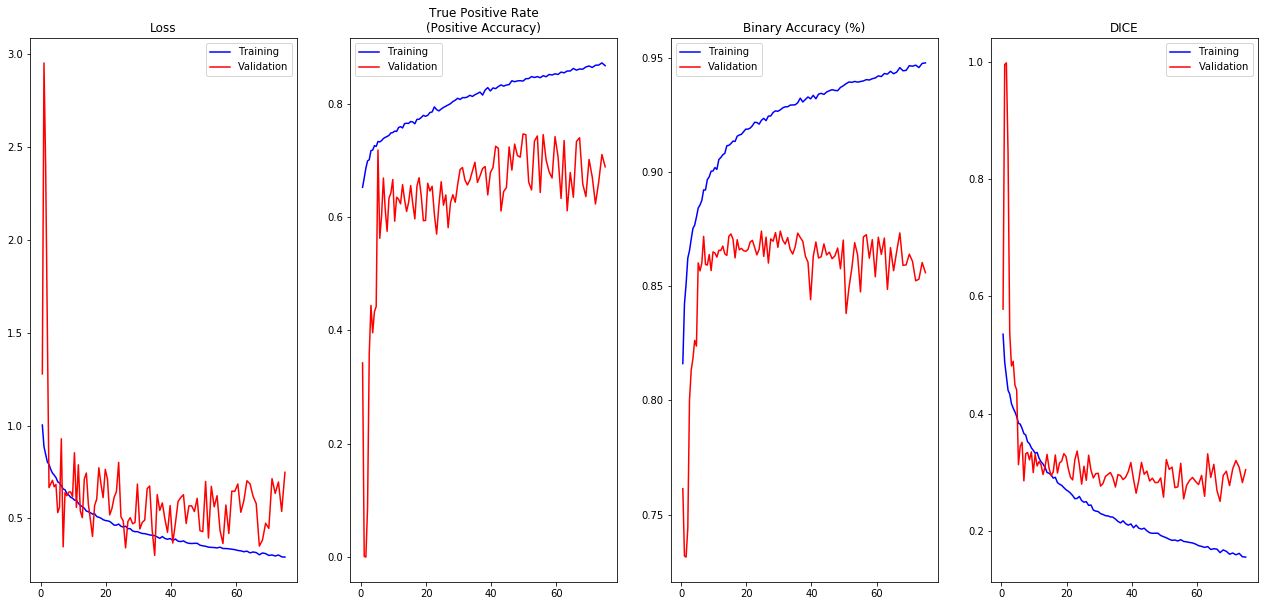

In [12]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_loss'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_loss'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)


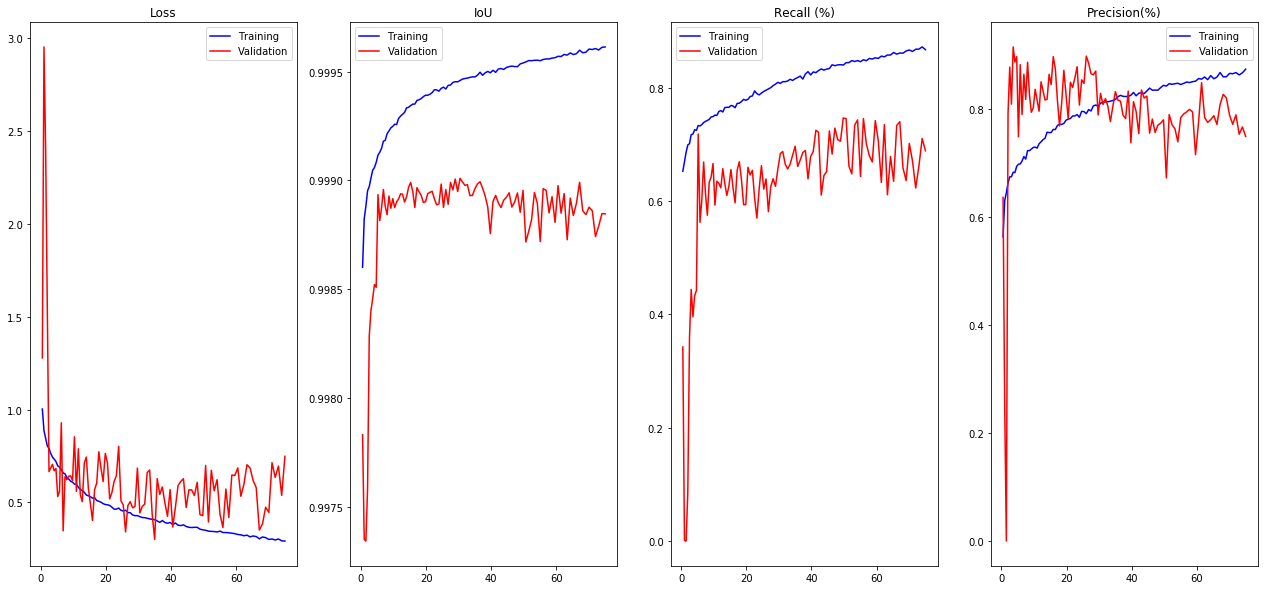

In [18]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['iou'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_iou'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('IoU')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['recall'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_recall'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Recall (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['precision'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_precision'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('Precision(%)')

show_loss(loss_history)


## Show evaluation results

0.96126753
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


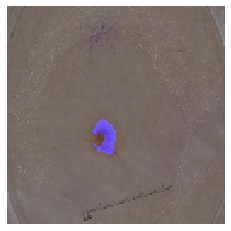

Hausdorff_Distance:
95.46203433826454
0.10204688
0.0
0.0
0.0
(128, 128, 1)
(128, 128, 3)


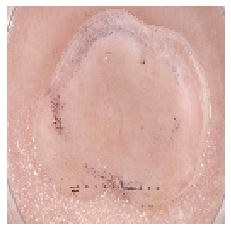

Hausdorff_Distance:
77.10382610480494
0.9999978
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


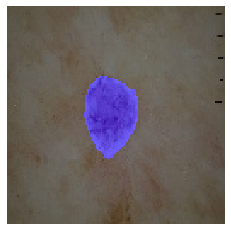

Hausdorff_Distance:
72.91776189653656
0.99999
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


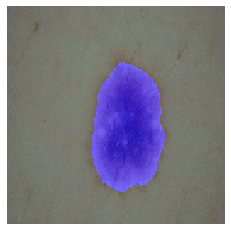

Hausdorff_Distance:
71.21797525905943
0.99992305
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


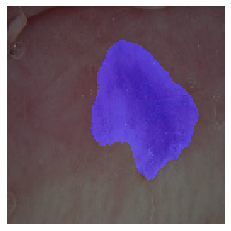

Hausdorff_Distance:
68.6804193347711
0.9999995
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


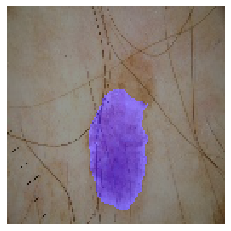

Hausdorff_Distance:
77.83315488916018
0.99914
2.682209e-07
255.0
0.0
(128, 128, 1)
(128, 128, 3)


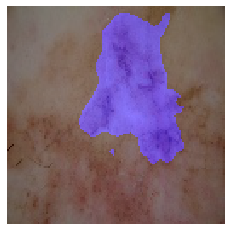

Hausdorff_Distance:
33.94112549695428
0.99999833
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


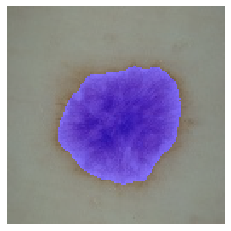

Hausdorff_Distance:
60.108235708594876
0.99999875
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


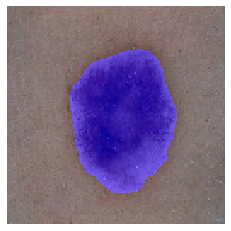

Hausdorff_Distance:
59.54829972383762
0.99999994
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


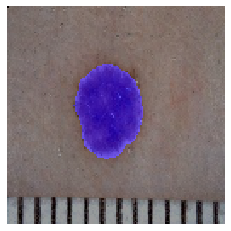

Hausdorff_Distance:
71.58910531638176
0.9999709
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


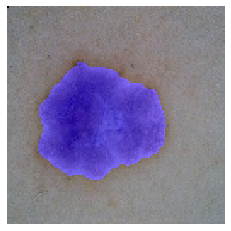

Hausdorff_Distance:
62.96824596572466
0.9999974
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


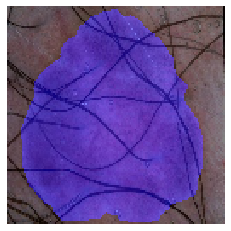

Hausdorff_Distance:
38.948684188300895
0.99999976
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


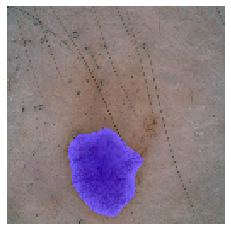

Hausdorff_Distance:
63.63961030678928
0.99999666
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


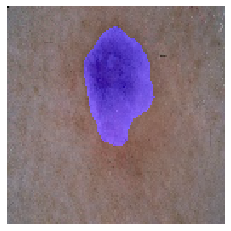

Hausdorff_Distance:
81.32035415564789
0.9999965
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


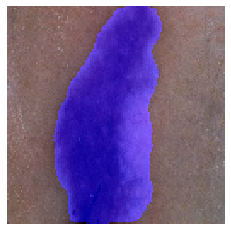

Hausdorff_Distance:
55.02726596879042
0.9999934
1.7881393e-07
255.0
0.0
(128, 128, 1)
(128, 128, 3)


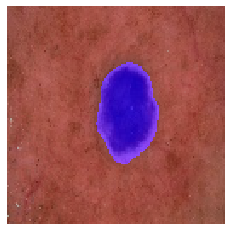

Hausdorff_Distance:
75.21303078589507
0.9999989
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


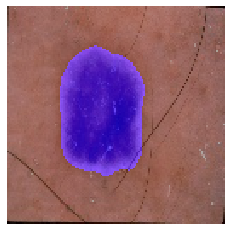

Hausdorff_Distance:
65.21502894272147
1.0
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


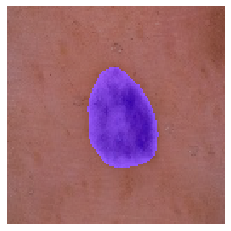

Hausdorff_Distance:
69.31089380465383
0.9780128
8.493662e-06
255.0
0.0
(128, 128, 1)
(128, 128, 3)


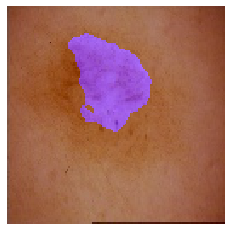

Hausdorff_Distance:
54.037024344425184
1.0
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


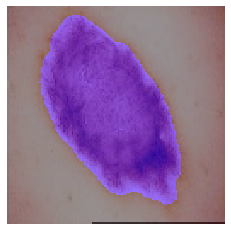

Hausdorff_Distance:
58.83026432033091
0.9999999
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


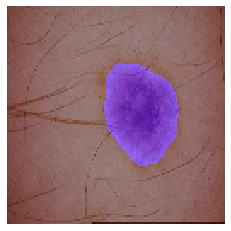

Hausdorff_Distance:
78.24321056807422
0.999999
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


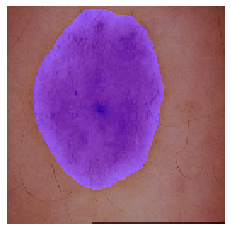

Hausdorff_Distance:
61.220911460055866
0.99999917
3.4570694e-06
255.0
0.0
(128, 128, 1)
(128, 128, 3)


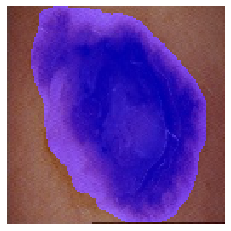

Hausdorff_Distance:
44.204072210600685
0.99998665
6.765127e-06
255.0
0.0
(128, 128, 1)
(128, 128, 3)


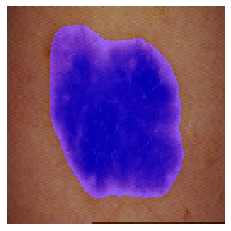

Hausdorff_Distance:
49.64876634922564
0.99995244
2.7120113e-05
255.0
0.0
(128, 128, 1)
(128, 128, 3)


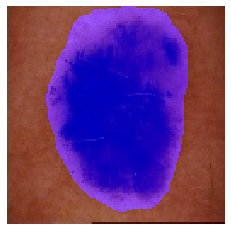

Hausdorff_Distance:
50.11985634456667
0.9999956
3.8415194e-05
255.0
0.0
(128, 128, 1)
(128, 128, 3)


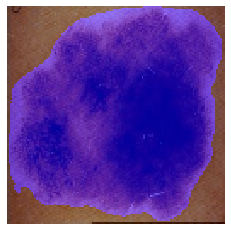

Hausdorff_Distance:
35.0
1.0
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


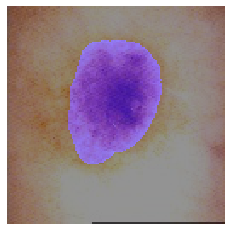

Hausdorff_Distance:
52.009614495783374
0.9999919
2.3245811e-06
255.0
0.0
(128, 128, 1)
(128, 128, 3)


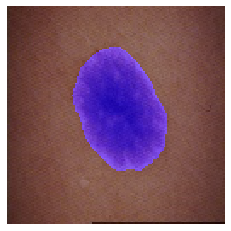

Hausdorff_Distance:
68.6804193347711
0.99998444
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


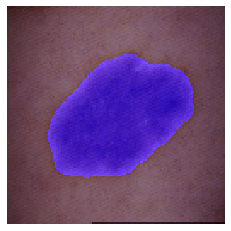

Hausdorff_Distance:
63.25345840347388
1.0
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


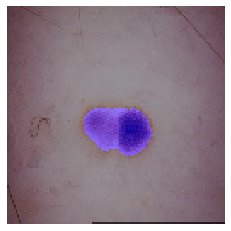

Hausdorff_Distance:
78.10249675906654
0.9999759
0.00029689074
255.0
0.0
(128, 128, 1)
(128, 128, 3)


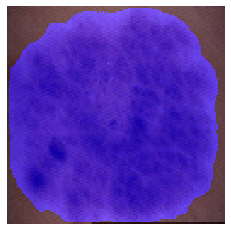

Hausdorff_Distance:
29.154759474226502
0.9999695
1.7881393e-07
255.0
0.0
(128, 128, 1)
(128, 128, 3)


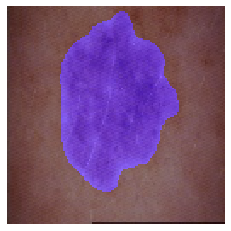

Hausdorff_Distance:
58.69412236331676
0.9999993
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


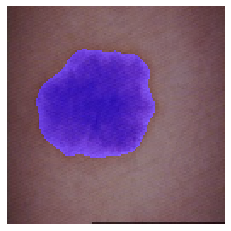

Hausdorff_Distance:
68.62215385719105
0.9996666
0.00028294325
255.0
0.0
(128, 128, 1)
(128, 128, 3)


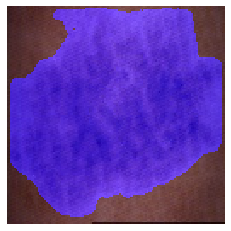

Hausdorff_Distance:
40.24922359499622
0.9999664
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


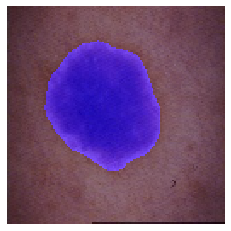

Hausdorff_Distance:
62.93647591023825
1.0
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


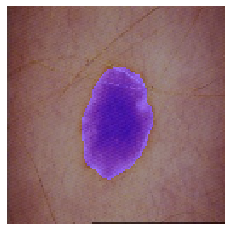

Hausdorff_Distance:
68.81860213634101
0.9999766
2.0861626e-07
255.0
0.0
(128, 128, 1)
(128, 128, 3)


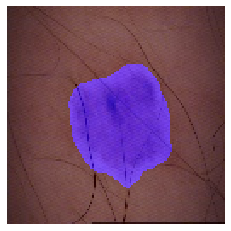

Hausdorff_Distance:
63.7808748764079
0.9999957
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


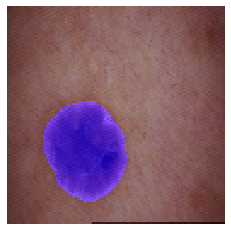

Hausdorff_Distance:
92.84934033152847
0.9999997
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


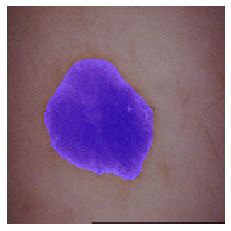

Hausdorff_Distance:
71.42128534267638
1.0
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


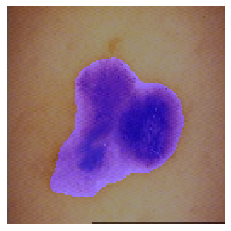

Hausdorff_Distance:
59.07622195096772
0.9999568
1.1026859e-06
255.0
0.0
(128, 128, 1)
(128, 128, 3)


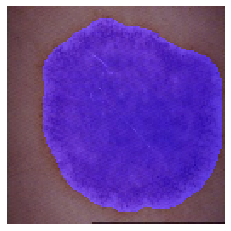

Hausdorff_Distance:
44.40720662234904
0.30358496
0.0
0.0
0.0
(128, 128, 1)
(128, 128, 3)


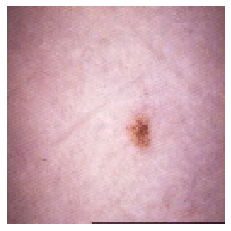

Hausdorff_Distance:
99.24716620639605
0.99996746
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


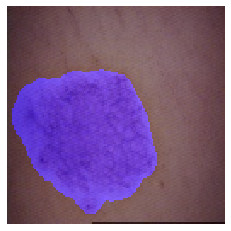

Hausdorff_Distance:
68.8839603971781
0.99999595
1.3709068e-06
255.0
0.0
(128, 128, 1)
(128, 128, 3)


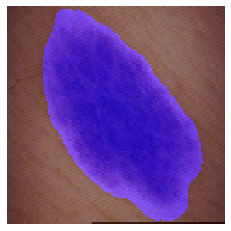

Hausdorff_Distance:
57.0087712549569
1.0
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


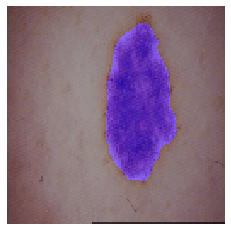

Hausdorff_Distance:
72.40165743959182
1.0
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


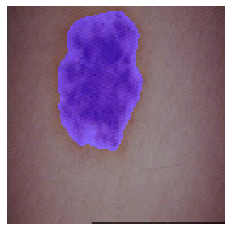

Hausdorff_Distance:
77.80102827083971
0.99999994
7.748604e-07
255.0
0.0
(128, 128, 1)
(128, 128, 3)


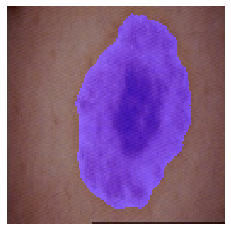

Hausdorff_Distance:
60.0
0.9999995
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


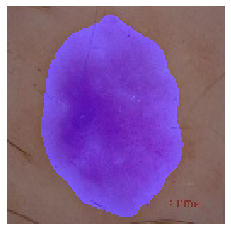

Hausdorff_Distance:
44.94441010848846
0.99998426
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


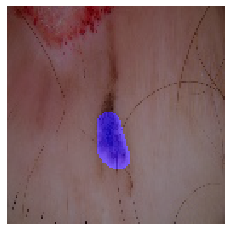

Hausdorff_Distance:
63.56099432828282
0.7548868
1.1503696e-05
255.0
0.0
(128, 128, 1)
(128, 128, 3)


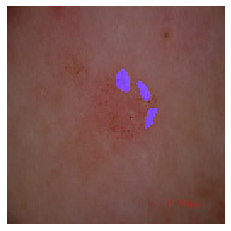

Hausdorff_Distance:
69.35416353759881
0.99999976
5.9604645e-08
255.0
0.0
(128, 128, 1)
(128, 128, 3)


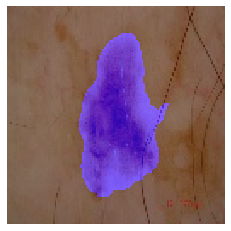

Hausdorff_Distance:
58.59180830116101
0.99999106
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


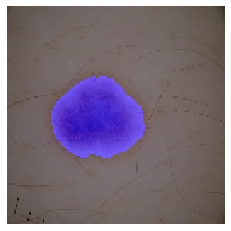

Hausdorff_Distance:
68.8839603971781
0.99999964
4.5597553e-05
255.0
0.0
(128, 128, 1)
(128, 128, 3)


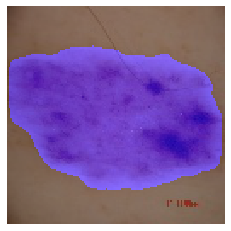

Hausdorff_Distance:
44.10215414239989
1.0
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


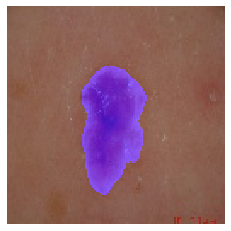

Hausdorff_Distance:
71.40028011149536
1.0
2.682209e-07
255.0
0.0
(128, 128, 1)
(128, 128, 3)


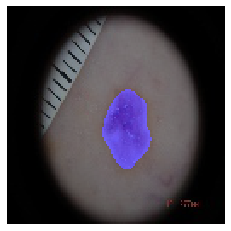

Hausdorff_Distance:
72.83543093852057
0.99997175
5.0485134e-05
255.0
0.0
(128, 128, 1)
(128, 128, 3)


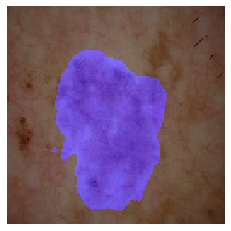

Hausdorff_Distance:
50.44799302251776
0.9999723
2.2232533e-05
255.0
0.0
(128, 128, 1)
(128, 128, 3)


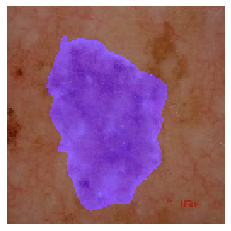

Hausdorff_Distance:
53.907327887774215
0.9999769
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


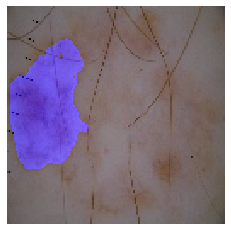

Hausdorff_Distance:
35.84689665786984
0.40397766
1.1920929e-07
0.0
0.0
(128, 128, 1)
(128, 128, 3)


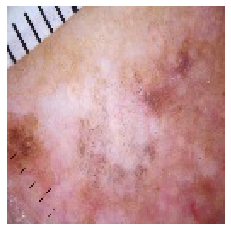

Hausdorff_Distance:
48.75448697299562
0.9999671
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


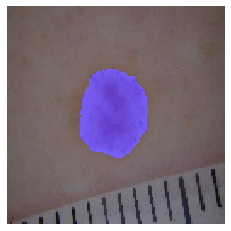

Hausdorff_Distance:
69.35416353759881
0.9999893
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


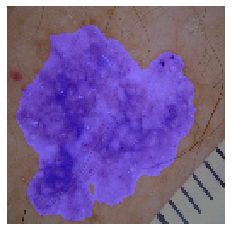

Hausdorff_Distance:
47.38143096192854
0.99862015
4.4703484e-06
255.0
0.0
(128, 128, 1)
(128, 128, 3)


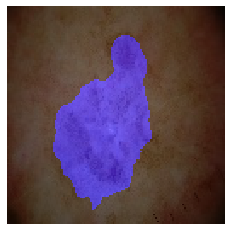

Hausdorff_Distance:
58.137767414994535
0.8643637
5.0365925e-06
255.0
0.0
(128, 128, 1)
(128, 128, 3)


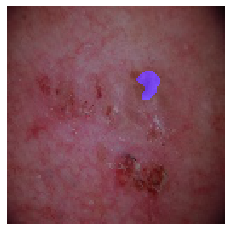

Hausdorff_Distance:
56.22277118748239
1.0
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


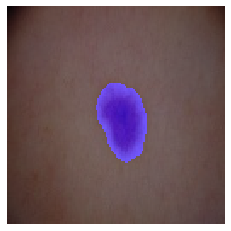

Hausdorff_Distance:
74.88658090739622
0.99999577
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


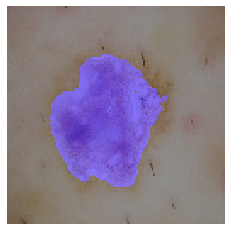

Hausdorff_Distance:
58.137767414994535
0.9999931
6.2584877e-07
255.0
0.0
(128, 128, 1)
(128, 128, 3)


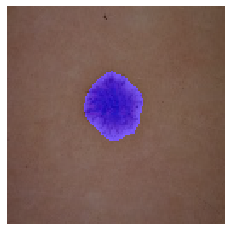

Hausdorff_Distance:
77.15568676384133
0.9999989
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


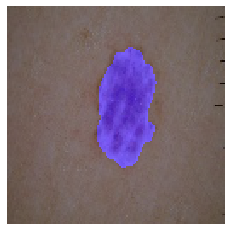

Hausdorff_Distance:
72.42237223399962
0.9999192
2.0861626e-07
255.0
0.0
(128, 128, 1)
(128, 128, 3)


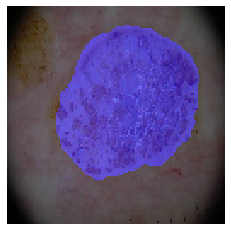

Hausdorff_Distance:
52.630789467763066
0.9997835
1.1920929e-07
255.0
0.0
(128, 128, 1)
(128, 128, 3)


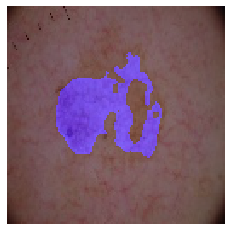

Hausdorff_Distance:
58.137767414994535
0.9999996
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


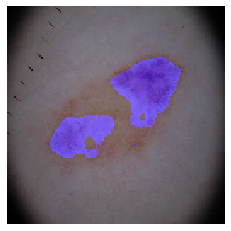

Hausdorff_Distance:
66.57326790837296
0.99999154
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


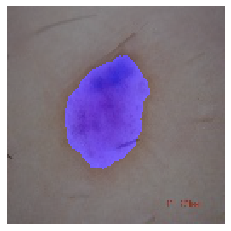

Hausdorff_Distance:
68.59300255857006
0.99999726
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


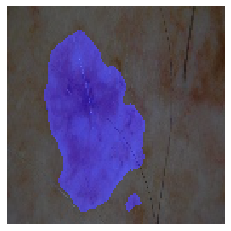

Hausdorff_Distance:
67.97793759742936
0.9997256
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


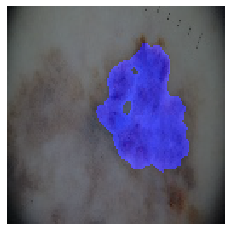

Hausdorff_Distance:
38.27531841800928
0.9999999
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


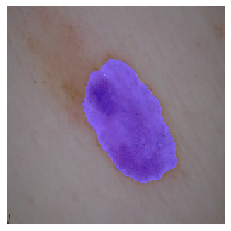

Hausdorff_Distance:
68.0
0.99999976
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


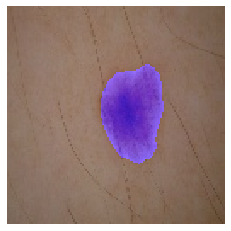

Hausdorff_Distance:
78.23042886243178
0.9999295
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


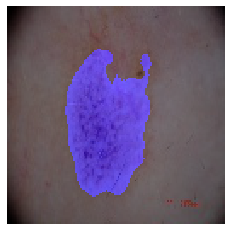

Hausdorff_Distance:
60.0
0.99998355
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


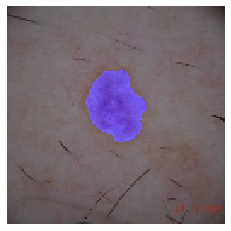

Hausdorff_Distance:
76.4198926981712
0.9999577
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


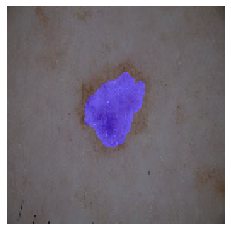

Hausdorff_Distance:
73.66138744281159
0.99999356
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


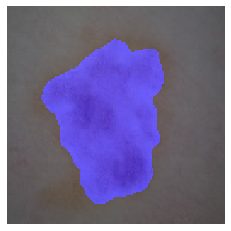

Hausdorff_Distance:
51.10772935672255
1.0
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


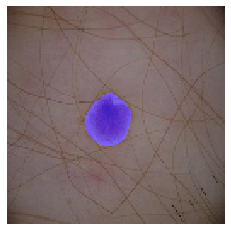

Hausdorff_Distance:
82.02438661763951
0.9999798
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


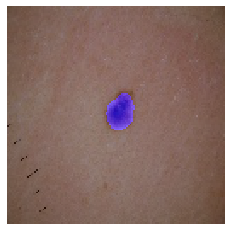

Hausdorff_Distance:
81.68843247363729
0.9999974
7.748604e-07
255.0
0.0
(128, 128, 1)
(128, 128, 3)


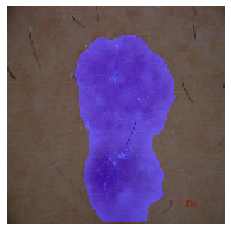

Hausdorff_Distance:
52.69724850502159
0.9995154
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


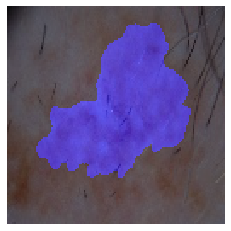

Hausdorff_Distance:
29.832867780352597
0.9999952
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


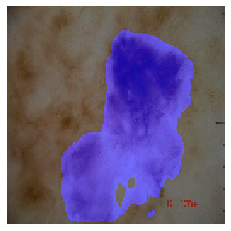

Hausdorff_Distance:
31.38470965295043
0.9999836
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


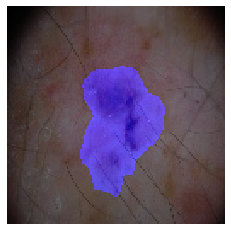

Hausdorff_Distance:
59.54829972383762
0.9998752
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


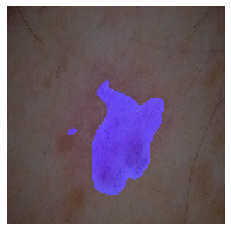

Hausdorff_Distance:
57.201398584300364
0.99999803
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


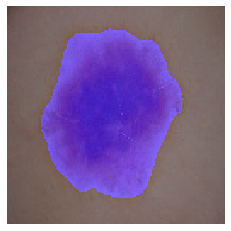

Hausdorff_Distance:
49.73932046178355
0.99999994
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


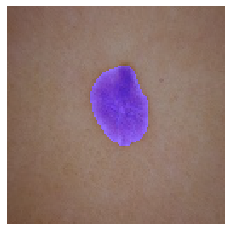

Hausdorff_Distance:
79.98124780221924
0.9999521
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


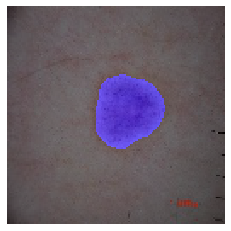

Hausdorff_Distance:
74.24957912338628
0.99999845
1.1622906e-06
255.0
0.0
(128, 128, 1)
(128, 128, 3)


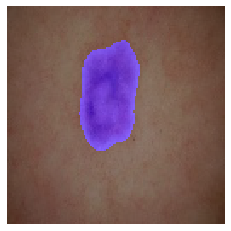

Hausdorff_Distance:
79.20858539325141
0.9999852
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


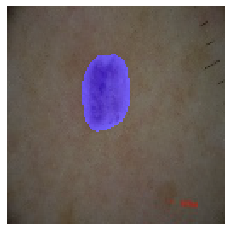

Hausdorff_Distance:
88.3911760301898
0.9997742
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


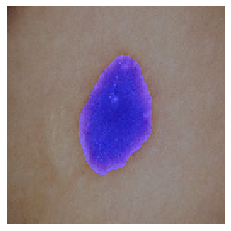

Hausdorff_Distance:
66.85057965343307
0.9999732
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


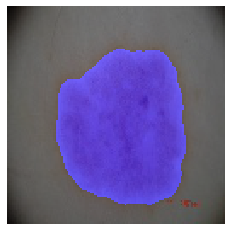

Hausdorff_Distance:
56.08029957123981
0.0035918057
5.90086e-06
0.0
0.0
(128, 128, 1)
(128, 128, 3)


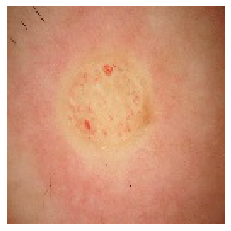

Hausdorff_Distance:
63.8200595424354
0.99999994
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


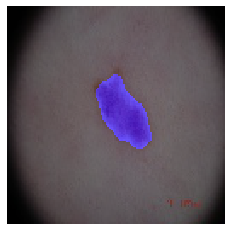

Hausdorff_Distance:
75.7429864739964
0.999898
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


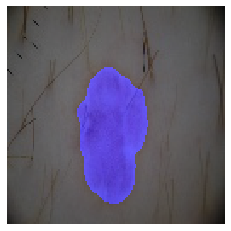

Hausdorff_Distance:
70.00714249274856
0.99999464
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


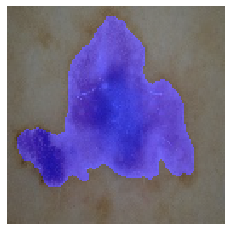

Hausdorff_Distance:
52.49761899362675
0.999999
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


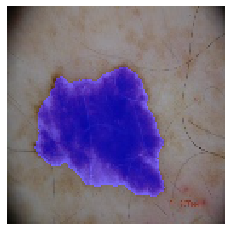

Hausdorff_Distance:
65.0
1.0
0.0
255.0
0.0
(128, 128, 1)
(128, 128, 3)


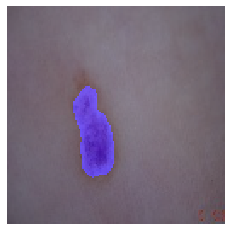

Hausdorff_Distance:
90.4267659490264
0.99999964
1.013279e-06
255.0
0.0
(128, 128, 1)
(128, 128, 3)


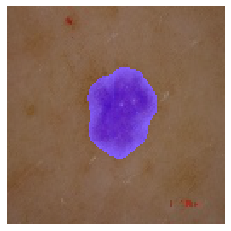

Hausdorff_Distance:
71.42128534267638
Dice_Coefficient:
0.8215548667253486
Average_Hausdorff:
63.22477955528011


In [14]:
model.load_weights(train_ckpt_path)
save_result(model, testImgDir, outDir, testImgDir)

### above result is with Unet++ model